# Using Segment Anything to create Custom 2D Visual Grounding Dataset

##### 1. This notebook demonstrates how SAM can be used to generate candidate masks of all entities in scene.
##### 2. Not all segmentations correspond to a meaningful object in scene. This notebook provides a helpful interface to screen all segmentations and save only the useful ones
##### 3. Once the RGB image - Mask pairs have been created, you can crowdsource the created parallel data to create referring queries.

In [ ]:
# Import all packages and libraries from Grounded-SAM
import sys
sys.path.append("/home/vineet/Desktop/Grounded-Segment-Anything/segment_anything")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from IPython.display import display, clear_output
import ipywidgets as widgets
import cv2

In [2]:
# Assign checkpoint path of the SAM model, and GPU device for faster inference.
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "/home/vineet/Downloads/sam_vit_h_4b8939.pth"
DEVICE = "cuda"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

In [3]:
def show_masks_and_save(image_path, masks, save_directory):
    """
    Displays the original image and then each object mask in black and white.
    Uses interactive buttons to let the user decide to save each mask as a PNG file.
    
    Parameters:
    - image_path: The path to the original image file.
    - masks: A list of dictionaries, where each dictionary has a key 'segmentation'
             corresponding to a True/False matrix for the object mask.
    - save_directory: The directory where mask images will be saved if the user chooses to do so.
    """
    # Ensure the save directory exists
    
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    save_counter = [0]
    def process_mask(index):
        if index < len(masks):
            mask_dict = masks[index]
            segmentation = mask_dict['segmentation']
            mask_image = np.where(segmentation, 0, 255).astype(np.uint8)

            clear_output(wait=True)
            plt.figure(figsize=(6, 6))
            plt.imshow(mask_image, cmap='gray', vmin=0, vmax=255)
            plt.axis('on')
            plt.title(f'Mask {index+1}')
            plt.show()

            # Display save and next buttons
            save_button = widgets.Button(description="Save Mask")
            next_button = widgets.Button(description="Next Mask")

            display(save_button, next_button)

            def save_mask(b):
                save_counter[0]+=1
                save_path = os.path.join(save_directory, image_name+f'_mask_{save_counter[0]}.png')
                Image.fromarray(mask_image).save(save_path)
                print(f'Mask saved as {save_path}')
                process_mask(index + 1)

            def next_mask(b):
                process_mask(index + 1)

            save_button.on_click(save_mask)
            next_button.on_click(next_mask)
        else:
            clear_output(wait=True)
            print("All masks processed. Total masks saved:", save_counter[0])

    process_mask(0)



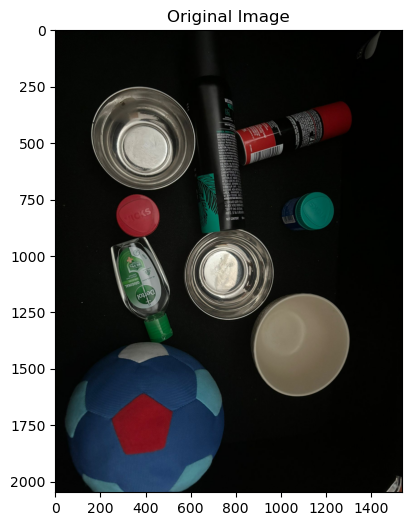

In [11]:
image_name="sample"
sample_image_path= './datasets/RoboRESTest/sample120.png'

original_image = Image.open(sample_image_path)
plt.figure(figsize=(6, 6))
plt.imshow(original_image)
plt.axis('on')
plt.title('Original Image')
plt.show()

In [12]:
print("Generating mask")
image= cv2.imread(sample_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
output_mask = mask_generator.generate(image_rgb)

Generating mask


In [ ]:
show_masks_and_save(sample_image_path, output_mask, './sample_masks/')

All masks processed. Total masks saved: 2
